In [1]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report

C:\Users\SAMRIDDHI PAUL\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\SAMRIDDHI PAUL\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\SAMRIDDHI PAUL\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/res

In [2]:
file_path = 'C:\\Users\\SAMRIDDHI PAUL\\fingerprint-based-blood-group-detection\\dataset\\dataset_blood_group'

# List all classes in the dataset
name_class = os.listdir(file_path)
print(name_class)

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [3]:
# Get file paths for all images in the dataset
filepaths = list(glob.glob(file_path + '/**/*.*'))

# Example of printing a subset of file paths
print(filepaths[-6:-1])

# Extract labels from file paths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
print(labels)

['C:\\Users\\SAMRIDDHI PAUL\\fingerprint-based-blood-group-detection\\dataset\\dataset_blood_group\\O-\\cluster_7_964.BMP', 'C:\\Users\\SAMRIDDHI PAUL\\fingerprint-based-blood-group-detection\\dataset\\dataset_blood_group\\O-\\cluster_7_977.BMP', 'C:\\Users\\SAMRIDDHI PAUL\\fingerprint-based-blood-group-detection\\dataset\\dataset_blood_group\\O-\\cluster_7_979.BMP', 'C:\\Users\\SAMRIDDHI PAUL\\fingerprint-based-blood-group-detection\\dataset\\dataset_blood_group\\O-\\cluster_7_985.BMP', 'C:\\Users\\SAMRIDDHI PAUL\\fingerprint-based-blood-group-detection\\dataset\\dataset_blood_group\\O-\\cluster_7_998.BMP']
['A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+',

                                            Filepath Label
0  C:\Users\SAMRIDDHI PAUL\fingerprint-based-bloo...    A+
1  C:\Users\SAMRIDDHI PAUL\fingerprint-based-bloo...    A+
2  C:\Users\SAMRIDDHI PAUL\fingerprint-based-bloo...    B-
3  C:\Users\SAMRIDDHI PAUL\fingerprint-based-bloo...    B-
4  C:\Users\SAMRIDDHI PAUL\fingerprint-based-bloo...    B+


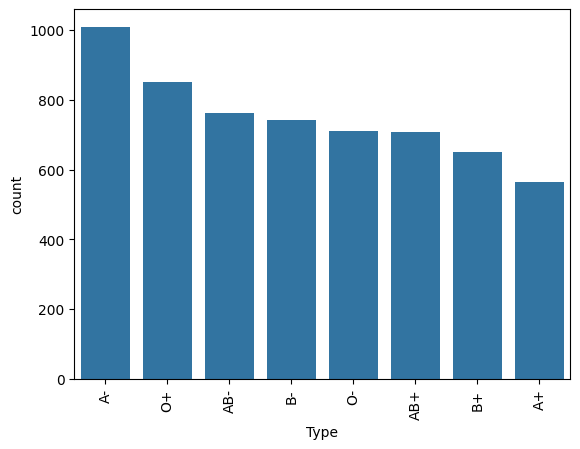

In [4]:
# Create a DataFrame with file paths and labels
filepath = pd.Series(filepaths, name='Filepath').astype(str)
Labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, Labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
print(data.head(5))

# Visualize class distribution
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)
plt.show()

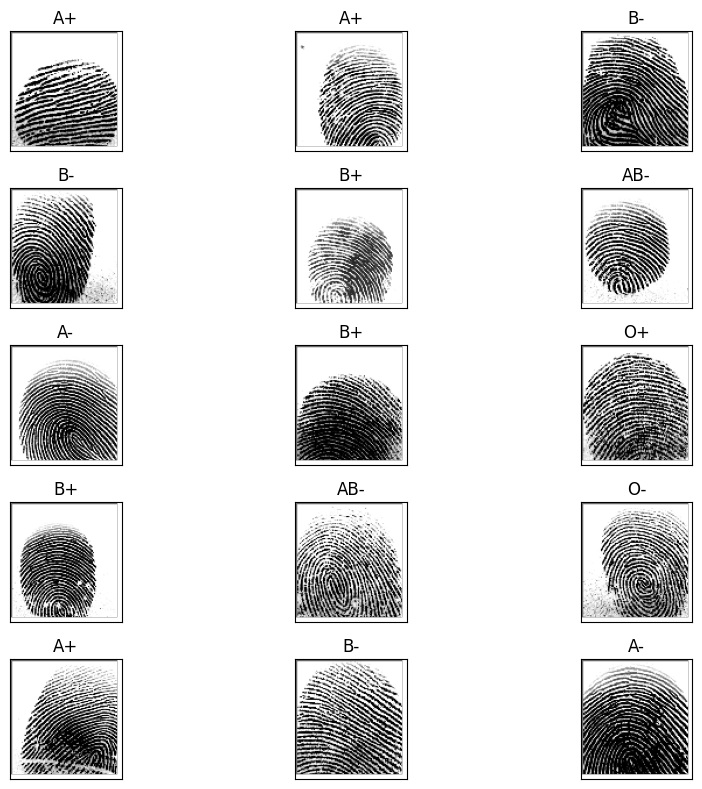

In [5]:
# Split data into training and testing sets
train, test = train_test_split(data, test_size=0.20, random_state=42)

# Visualize some images from the dataset
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [6]:
# Set up ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 4800 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


In [7]:
# Define the base pre-trained model
pretrained_model = ResNet50(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# Add layers for classification on top of ResNet50
x = Dense(128, activation="relu")(pretrained_model.output)
x = Dense(128, activation="relu")(x)
outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


C:\Users\SAMRIDDHI PAUL\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1313s 9s/step - accuracy: 0.5423 - loss: 1.1862 - val_accuracy: 0.6517 - val_loss: 0.8681
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 752s 5s/step - accuracy: 0.7021 - loss: 0.7689 - val_accuracy: 0.6808 - val_loss: 0.8219
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3295s 22s/step - accuracy: 0.7581 - loss: 0.6182 - val_accuracy: 0.7050 - val_loss: 0.7566
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.7908 - loss: 0.5295 - val_accuracy: 0.7408 - val_loss: 0.6634
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3718s 25s/step - accuracy: 0.8112 - loss: 0.4861 - val_accuracy: 0.7658 - val_loss: 0.6231
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1897s 13s/step - accuracy: 0.8317 - loss: 0.4262 - val_accuracy: 0.7792 - val_loss: 0.5932
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 978s 7s/step - accuracy: 0.8556 - loss: 0.3728 - val_accuracy: 0.7775 - val_loss: 0.5734
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.8654 - loss: 0.3335 - v

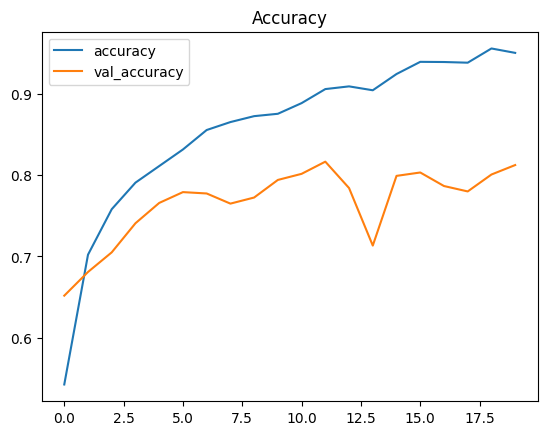

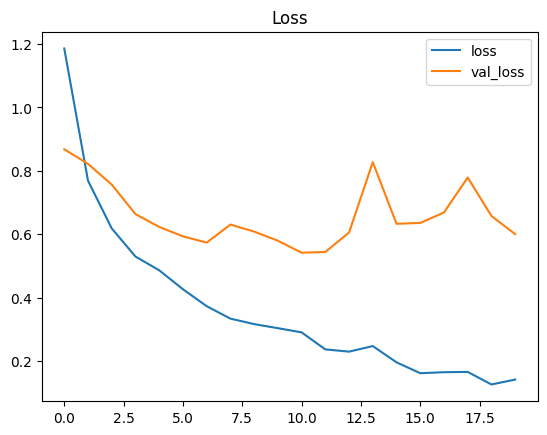

Test Loss: 0.60026
Test Accuracy: 81.25%
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step
              precision    recall  f1-score   support

          A+       0.96      0.79      0.86       109
          A-       0.82      0.76      0.79       194
         AB+       0.72      0.80      0.76       127
         AB-       0.83      0.84      0.84       150
          B+       0.83      0.75      0.79       128
          B-       0.91      0.85      0.88       169
          O+       0.77      0.85      0.81       179
          O-       0.74      0.83      0.78       144

    accuracy                           0.81      1200
   macro avg       0.82      0.81      0.81      1200
weighted avg       0.82      0.81      0.81      1200



In [8]:
# Plot training history: accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plot training history: loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

# Evaluate the model on test data
results = model.evaluate(valid_gen, verbose=0)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

# Predict labels for test data
pred = model.predict(valid_gen)
pred = np.argmax(pred, axis=1)

# Map predicted labels
labels = train_gen.class_indices
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Compare predicted labels with true labels and print classification report
y_test = list(test.Label)
print(classification_report(y_test, pred))

In [9]:
model.save("model_blood_group_detection.h5")

In [10]:
train_gen.class_indices

{'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


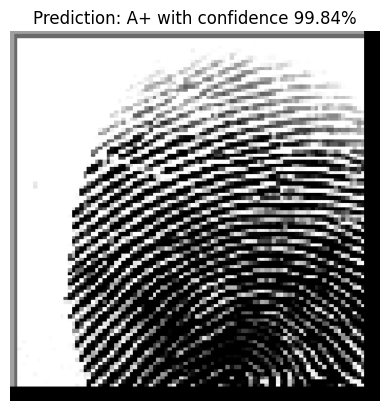

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Load the pre-trained model
model = load_model('model_blood_group_detection.h5')

# Define the class labels
labels = {'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}
labels = dict((v, k) for k, v in labels.items())

# Example of loading a single image and making a prediction
img_path = 'C:\\Users\\SAMRIDDHI PAUL\\fingerprint-based-blood-group-detection\\dataset\\dataset_blood_group\\A+\\cluster_0_1001.BMP'


img = image.load_img(img_path, target_size=(256, 256))  # Load the image
x = image.img_to_array(img)  # Convert image to array
x = np.expand_dims(x, axis=0)  # Expand dimensions to match the model input
x = preprocess_input(x)  # Preprocess the image

result = model.predict(x)  # Predict using the model
predicted_class = np.argmax(result)  # Get the predicted class index

# Map the predicted class to the label
predicted_label = labels[predicted_class]
confidence = result[0][predicted_class] * 100  # Confidence level

# Display the image
plt.imshow(image.array_to_img(image.img_to_array(img) / 255.0))
plt.axis('off')  # Hide axes

# Display the prediction and confidence below the image
plt.title(f"Prediction: {predicted_label} with confidence {confidence:.2f}%")
plt.show()
